## Relative dispersion calculations with LASER drifters
**06 December 2023 by MiniUFO**

---
[TOC]

---
### 1. Introduction
Following [Beron-Vera and LaCasce](https://journals.ametsoc.org/view/journals/phoc/46/7/jpo-d-15-0127.1.xml), relative dispersion analysis will be performed using LASER drifter dataset.  Also, the newly proposed [Cumulative Inverse Separation Time (CIST)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/relative-dispersion-with-finite-inertial-ranges/A4810AD4971C9C9FC920CE4BDAF8AE95) diagnostic will be calculated to infer the turbulent regime of the real ocean.

### 2. Calculation procedure
#### 2.1 load the LASER datasetformat

In [1]:
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

tinterval = 0.25 # hour
Rearth = 6371.20 # km

def load_LASER_drifters(path, check_interval=True):
    ds = xr.open_dataset(path).drop_vars(['ID','rowsize'])
    
    drifters = []
    ids = []
    
    for ID, dr in ds.groupby('ids'):
        dr.attrs['ID'] = ID
        drifters.append(dr.swap_dims({'obs':'time'}).drop('ids'))
    
    if check_interval: # check the time interval is 0.25 hour
        for dr in drifters:
            tt = dr.time.values
            if not ((tt[1:] - tt[:-1]) / np.timedelta64(1, 'h') == tinterval).all():
                ids.append(dr.attrs['ID'])

    print(f'there are {len(drifters)} drifters in the dataset')
    
    return drifters, ids

drifters, ids = load_LASER_drifters('../data/laser32_drogued_remove_first.nc')

there are 956 drifters in the dataset


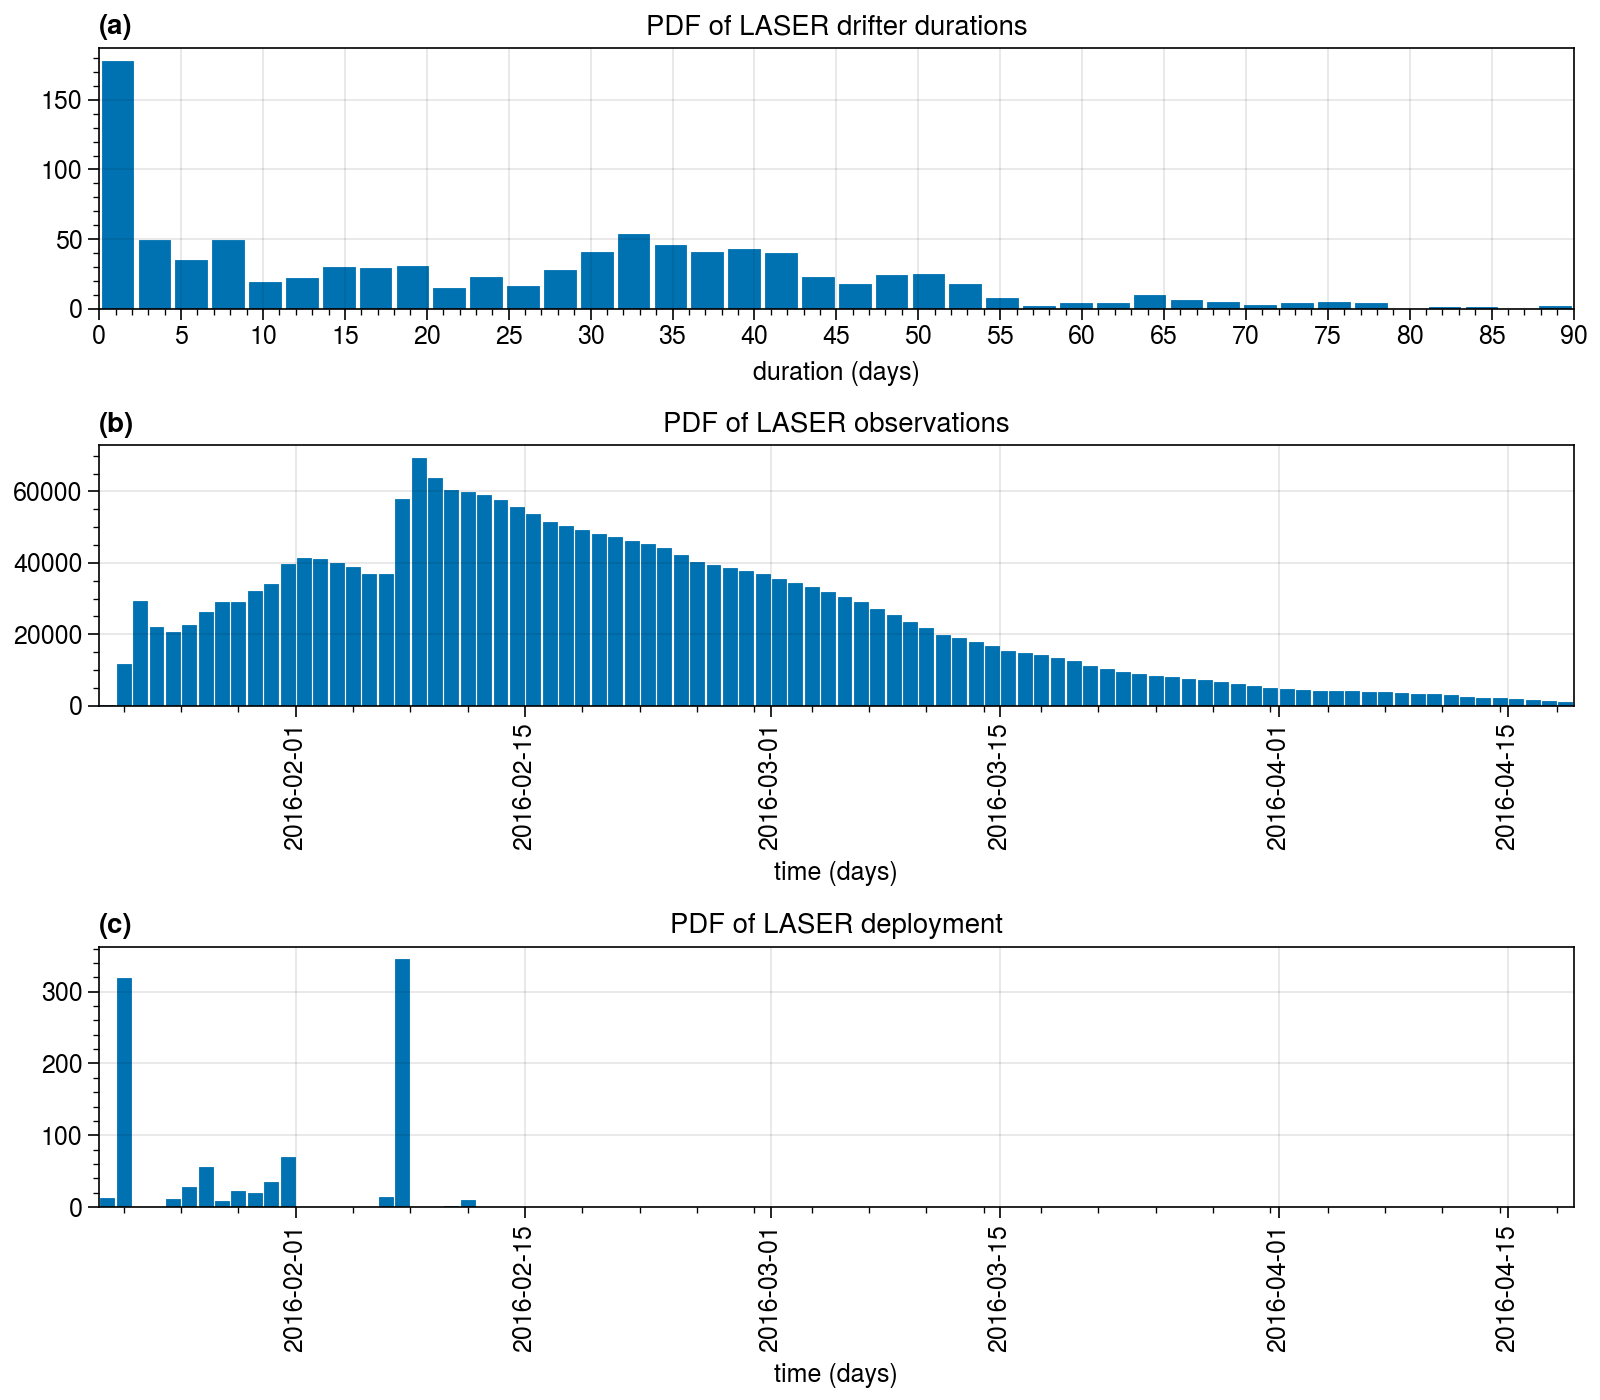

In [2]:
import proplot as pplt

fig, axes = pplt.subplots(nrows=3, figsize=(8,7), facecolor='w', sharex=0, sharey=0)

init = np.array([len(dr.time) / (4.0*24.0) for dr in drifters])
ax = axes[0]
_ = ax.hist(init, bins=np.linspace(0, 90, 41), rwidth=0.86)  # arguments are passed to np.histogram
ax.set_xlim([0, 90])
ax.set_xticks(np.linspace(0, 90, 19))
ax.set_xlabel('duration (days)')
ax.set_title("PDF of LASER drifter durations")

init = np.hstack([dr.time for dr in drifters])
ax = axes[1]
bins = np.arange('2016-01-20', '2016-04-20', dtype='datetime64[D]')
_ = ax.hist(init, bins=bins,
            rwidth=0.85)  # arguments are passed to np.histogram
ax.set_xlim(bins[0], bins[-1])
ax.set_xlabel('time (days)')
ax.set_title("PDF of LASER observations")

init = np.hstack([dr.time[0] for dr in drifters])
ax = axes[2]
bins = np.arange('2016-01-20', '2016-04-20', dtype='datetime64[D]')
_ = ax.hist(init, bins=bins,
            rwidth=0.85)  # arguments are passed to np.histogram
ax.set_xlim(bins[0], bins[-1])
ax.set_xlabel('time (days)')
ax.set_title("PDF of LASER deployment")

axes.format(abc='(a)')

#### 2.2 Construct RelativeDispersion class and make particle pairs

In [3]:
import sys
sys.path.append('../')
from core import RelativeDispersion
from tqdm import tqdm

rd = RelativeDispersion(xpos='longitude', uvel='ve', time='time', Rearth=6371.2,
                        ypos='latitude' , vvel='vn', coord='latlon')

duration = 10 # find pairs longer than duration

tmp = []
for dr in drifters:
    if len(dr.time) >= duration * 4 * 24:
        tmp.append(dr)

pairs = rd.group_pairs(tmp)

initials = []
minimums = []
mintimes = []
for p in tqdm(pairs, ncols=100):
    aligned = rd._align_by_time(p)
    if aligned != None:
        rx, ry, rxy, r, _, _, _, _, _, _, _ = rd._stat_rv(aligned)
        initials.append(r[0].values)
        minimums.append(r.min().values)
        mintimes.append(r.time[r.argmin('time')].values)

there are 201930 pairs of particles


100%|██████████████████████████████████████████████████████| 201930/201930 [32:05<00:00, 104.88it/s]


Text(0.5, 1.0, 'PDF of $r_0$ for LASER drifters (> 10 days)')

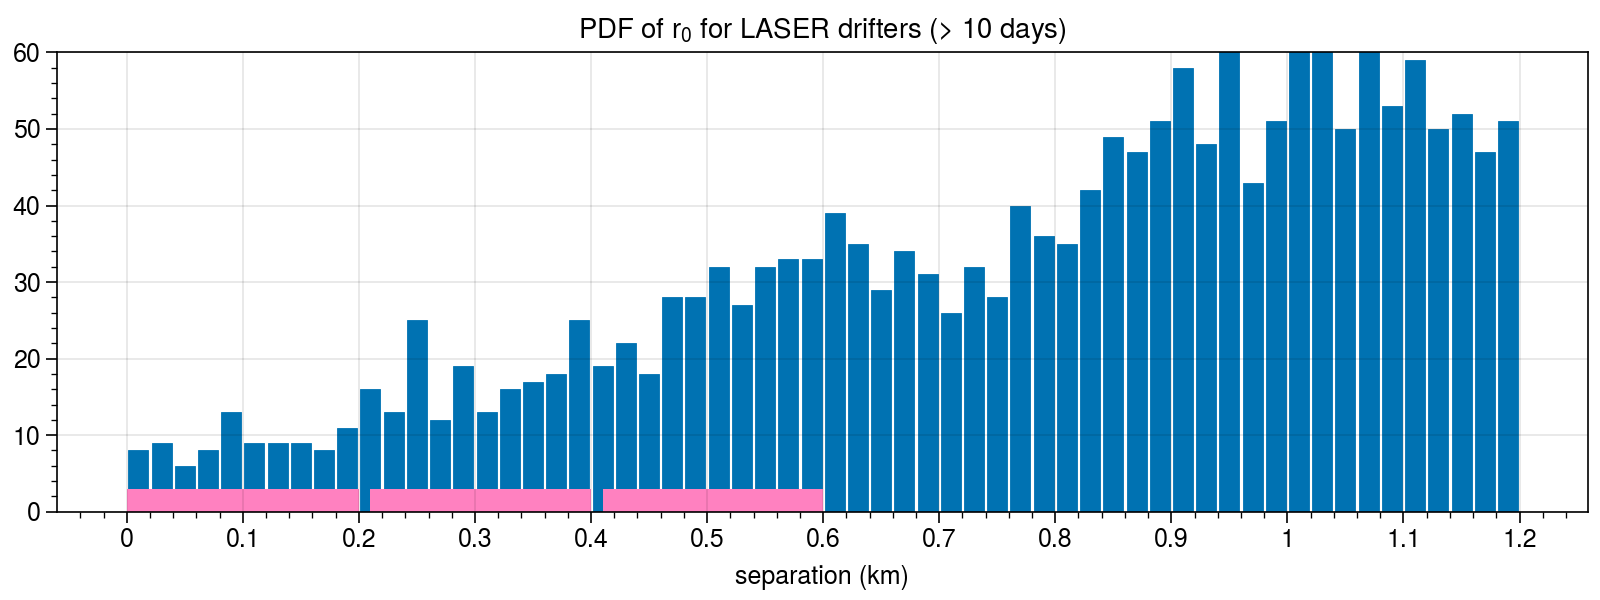

In [4]:
import proplot as pplt
from matplotlib.patches import Rectangle

init = np.array(initials)
fig, ax = pplt.subplots(figsize=(8,3), facecolor='w')
_ = ax.hist(init, bins=np.linspace(0, 1.2, 61), rwidth=0.86)  # arguments are passed to np.histogram
x1, x2 = 0, 0.2
ax.add_patch(Rectangle((x1, 0), x2-x1, 3, facecolor='pink'))
x1, x2 = 0.21, 0.4
ax.add_patch(Rectangle((x1, 0), x2-x1, 3, facecolor='pink'))
x1, x2 = 0.41, 0.6
ax.add_patch(Rectangle((x1, 0), x2-x1, 3, facecolor='pink'))
ax.set_xlabel('separation (km)')
ax.set_ylim([0, 60])
ax.set_xticks(np.linspace(0, 1.2, 13))
r0 = '$r_0$'
ax.set_title(f"PDF of {r0} for LASER drifters (> {duration} days)")

Text(0.5, 1.0, 'PDF of $r_0$ for LASER drifters (> 10 days)')

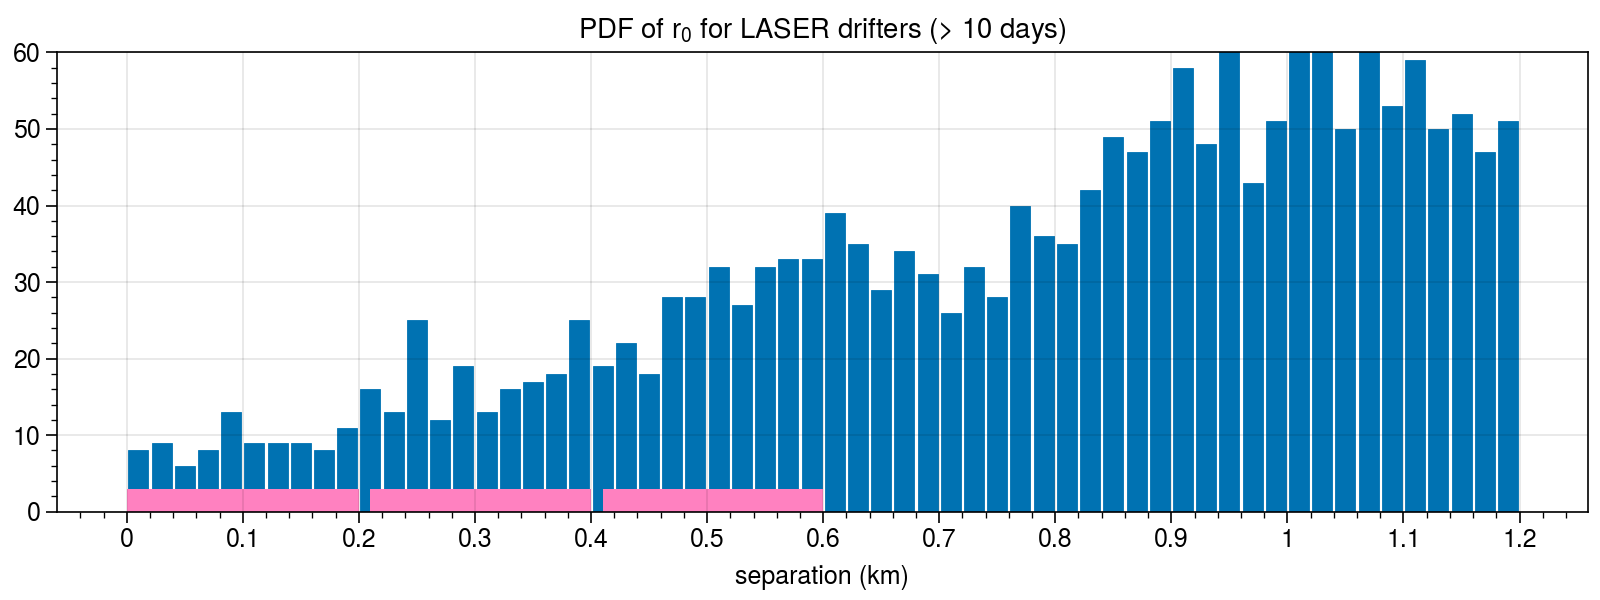

In [5]:
import proplot as pplt
from matplotlib.patches import Rectangle

init = np.array(initials)
fig, ax = pplt.subplots(figsize=(8,3), facecolor='w')
_ = ax.hist(init, bins=np.linspace(0, 1.2, 61), rwidth=0.86)  # arguments are passed to np.histogram
x1, x2 = 0, 0.2
ax.add_patch(Rectangle((x1, 0), x2-x1, 3, facecolor='pink'))
x1, x2 = 0.21, 0.4
ax.add_patch(Rectangle((x1, 0), x2-x1, 3, facecolor='pink'))
x1, x2 = 0.41, 0.6
ax.add_patch(Rectangle((x1, 0), x2-x1, 3, facecolor='pink'))
ax.set_xlabel('separation (km)')
ax.set_ylim([0, 60])
ax.set_xticks(np.linspace(0, 1.2, 13))
r0 = '$r_0$'
ax.set_title(f"PDF of {r0} for LASER drifters (> {duration} days)")

Text(0.5, 1.0, 'PDF of $r_{min}$ for LASER pairs (> 10 days)')

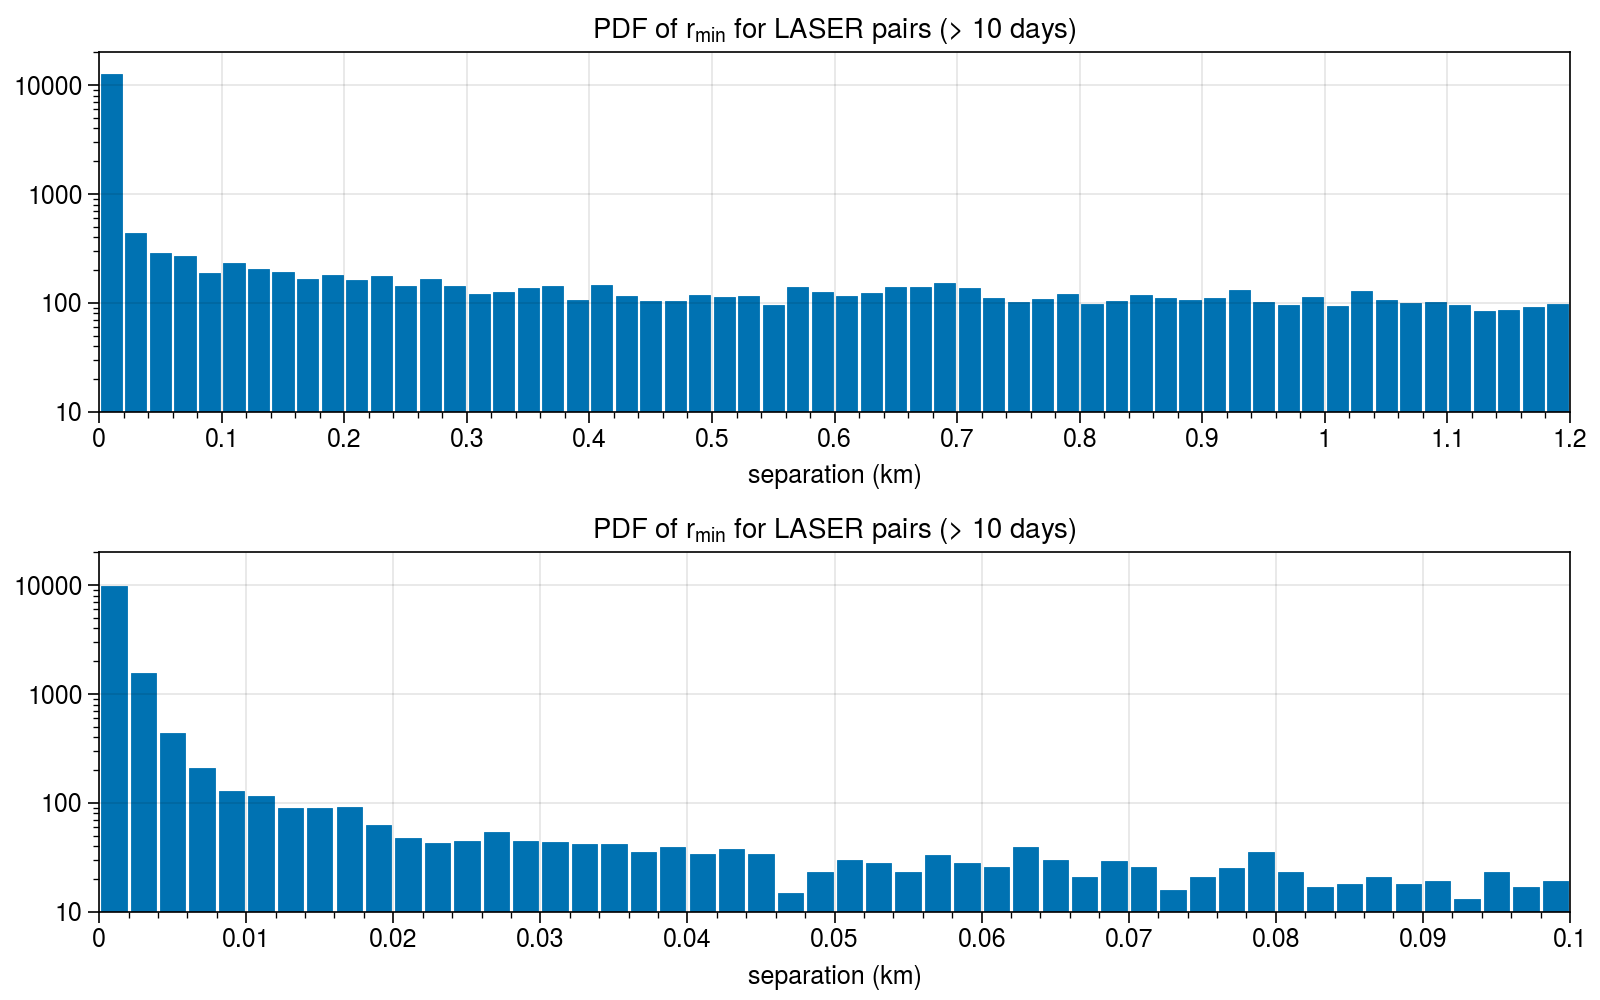

In [6]:
import proplot as pplt
from matplotlib.patches import Rectangle

init = np.array(minimums)
fig, axes = pplt.subplots(nrows=2, figsize=(8,5), facecolor='w', sharex=0)
rmin = '$r_{min}$'

ax = axes[0]
_ = ax.hist(init, bins=np.linspace(0, 1.2, 61), rwidth=0.86)  # arguments are passed to np.histogram
ax.set_xlabel('separation (km)')
ax.set_ylim([1e1, 2e4])
ax.set_yscale('log')
ax.set_xticks(np.linspace(0, 1.2, 13))
ax.set_xlim([0, 1.2])
ax.set_title(f"PDF of {rmin} for LASER pairs (> {duration} days)")

ax = axes[1]
_ = ax.hist(init, bins=np.linspace(0, 0.1, 51), rwidth=0.86)  # arguments are passed to np.histogram
ax.set_xlabel('separation (km)')
ax.set_ylim([1e1, 2e4])
ax.set_yscale('log')
ax.set_xticks(np.linspace(0, 0.1, 11))
ax.set_xlim([0, 0.1])
ax.set_title(f"PDF of {rmin} for LASER pairs (> {duration} days)")

Text(0.5, 1.0, 'PDF of $r_{min}$ for LASER drifters (> 10 days)')

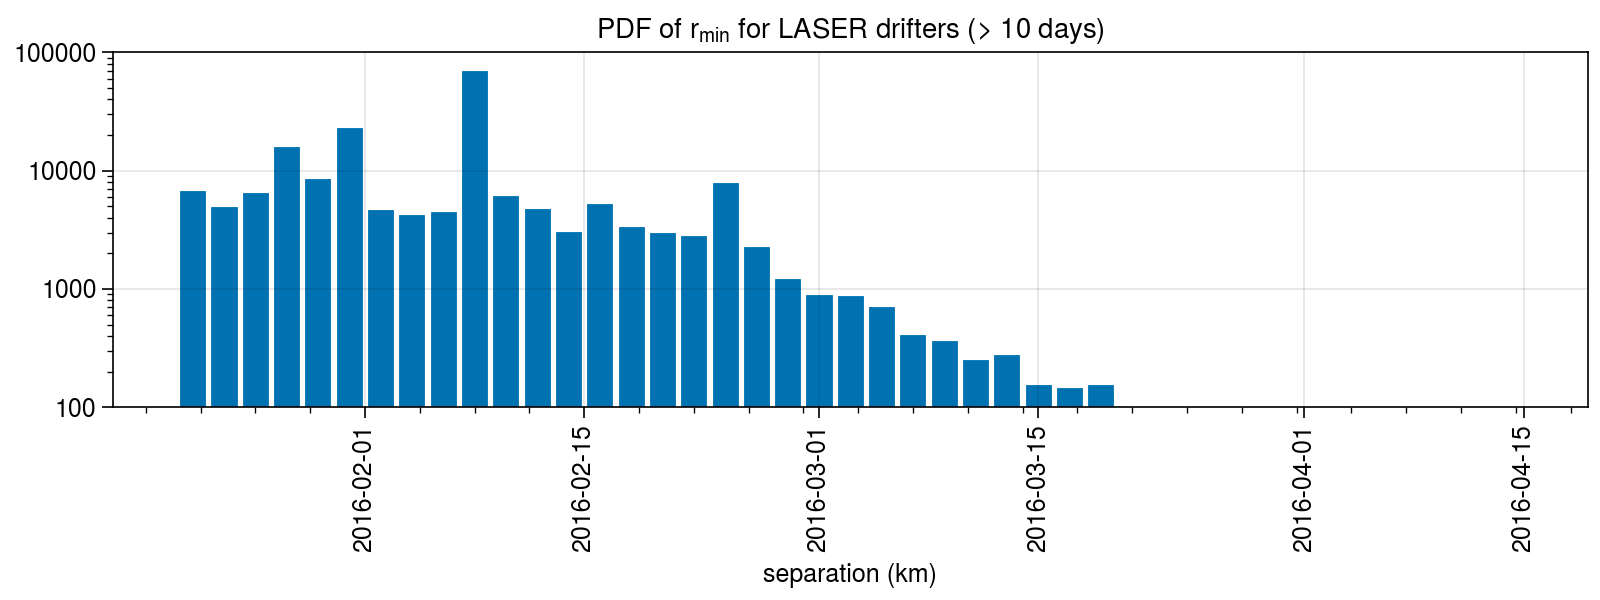

In [7]:
import proplot as pplt
from matplotlib.patches import Rectangle

#mintimes2 = [a.values for a in mintimes]

init = np.asarray(mintimes)

fig, ax = pplt.subplots(figsize=(8,3), facecolor='w')
_ = ax.hist(init, bins=np.arange(np.datetime64('2016-01-20'),
                                 np.datetime64('2016-04-17'), np.timedelta64(2, 'D')), rwidth=0.8)  # arguments are passed to np.histogram
ax.set_xlabel('separation (km)')
ax.set_ylim([1e2, 1e5])
ax.set_yscale('log')
rmin = '$r_{min}$'
ax.set_title(f"PDF of {rmin} for LASER drifters (> {duration} days)")

In [8]:
origins, chances = rd.find_pairs(pairs, [[0.10,  0.20],  # r0 = 0.15
                                         [0.15,  0.25],  # r0 = 0.2
                                         [0.20,  0.30],  # r0 = 0.25
                                         [0.25,  0.35],  # r0 = 0.3
                                         [0.30,  0.40],  # r0 = 0.35
                                         [0.35,  0.45],  # r0 = 0.4
                                         [0.40,  0.50],  # r0 = 0.45
                                         [0.45,  0.55],  # r0 = 0.5
                                         [0.50,  0.60]], # r0 = 0.55
                                         chancePair=True, t_frac=0.000001, tlen=4*24*10, first=False)

#%% define groups and assign relative time coordinate
groups_O = origins
groups_C = chances
r0s = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
gNames = [f'{r0s[0]}km', f'{r0s[1]}km', f'{r0s[2]}km', f'{r0s[3]}km', f'{r0s[4]}km', f'{r0s[5]}km',
          f'{r0s[6]}km', f'{r0s[7]}km', f'{r0s[8]}km']

for go, gc in zip(groups_O, groups_C):
    for pair in go:
        dr1, dr2 = pair
        dr1['time'] = np.arange(len(dr1.time)) * 15.0 / (60. * 24.)
        dr2['time'] = np.arange(len(dr2.time)) * 15.0 / (60. * 24.)
    
    for pair in gc:
        dr1, dr2 = pair
        dr1['time'] = np.arange(len(dr1.time)) * 15.0 / (60. * 24.)
        dr2['time'] = np.arange(len(dr2.time)) * 15.0 / (60. * 24.)

100%|██████████████████████████████████| 201930/201930 [11:42<00:00, 287.32it/s]


original pairs: 46, chance pairs: 955, with r0 in [0.1, 0.2]
original pairs: 67, chance pairs: 840, with r0 in [0.15, 0.25]
original pairs: 85, chance pairs: 769, with r0 in [0.2, 0.3]
original pairs: 79, chance pairs: 673, with r0 in [0.25, 0.35]
original pairs: 89, chance pairs: 617, with r0 in [0.3, 0.4]
original pairs: 102, chance pairs: 618, with r0 in [0.35, 0.45]
original pairs: 115, chance pairs: 575, with r0 in [0.4, 0.5]
original pairs: 140, chance pairs: 537, with r0 in [0.45, 0.55]
original pairs: 157, chance pairs: 579, with r0 in [0.5, 0.6]


In [9]:
count = 0

def same(p1, p2):
    lens = min(len(p1.longitude), len(p2.longitude))
    return (p1.longitude[0:lens] == p2.longitude[0:lens]).all().values and (p1.latitude[0:lens] == p2.latitude[0:lens]).all().values

dup = []
chancesN = []
for cpair in tqdm(chances[1]):
    c1, c2 = cpair
    is_dup = False
    for opair in origins[1]:
        o1, o2 = opair

        if (same(o1, c1) and same(o2, c2)) or (same(o1, c2) and same(o2, c1)):
            dup.append(cpair)
            count = count + 1
            is_dup = True
            break

    if not is_dup:
        chancesN.append(cpair)

print(f'there are {len(origins[1])} original and {len(chances[1])} chance pairs.   {len(dup)} original pairs duplicated in chance pairs')
print(len(chancesN))

totalpairs = origins[1]+chancesN
print(f'original + chance pairs are {len(totalpairs)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:41<00:00, 20.02it/s]

there are 67 original and 840 chance pairs.   9 original pairs duplicated in chance pairs
831
original + chance pairs are 898


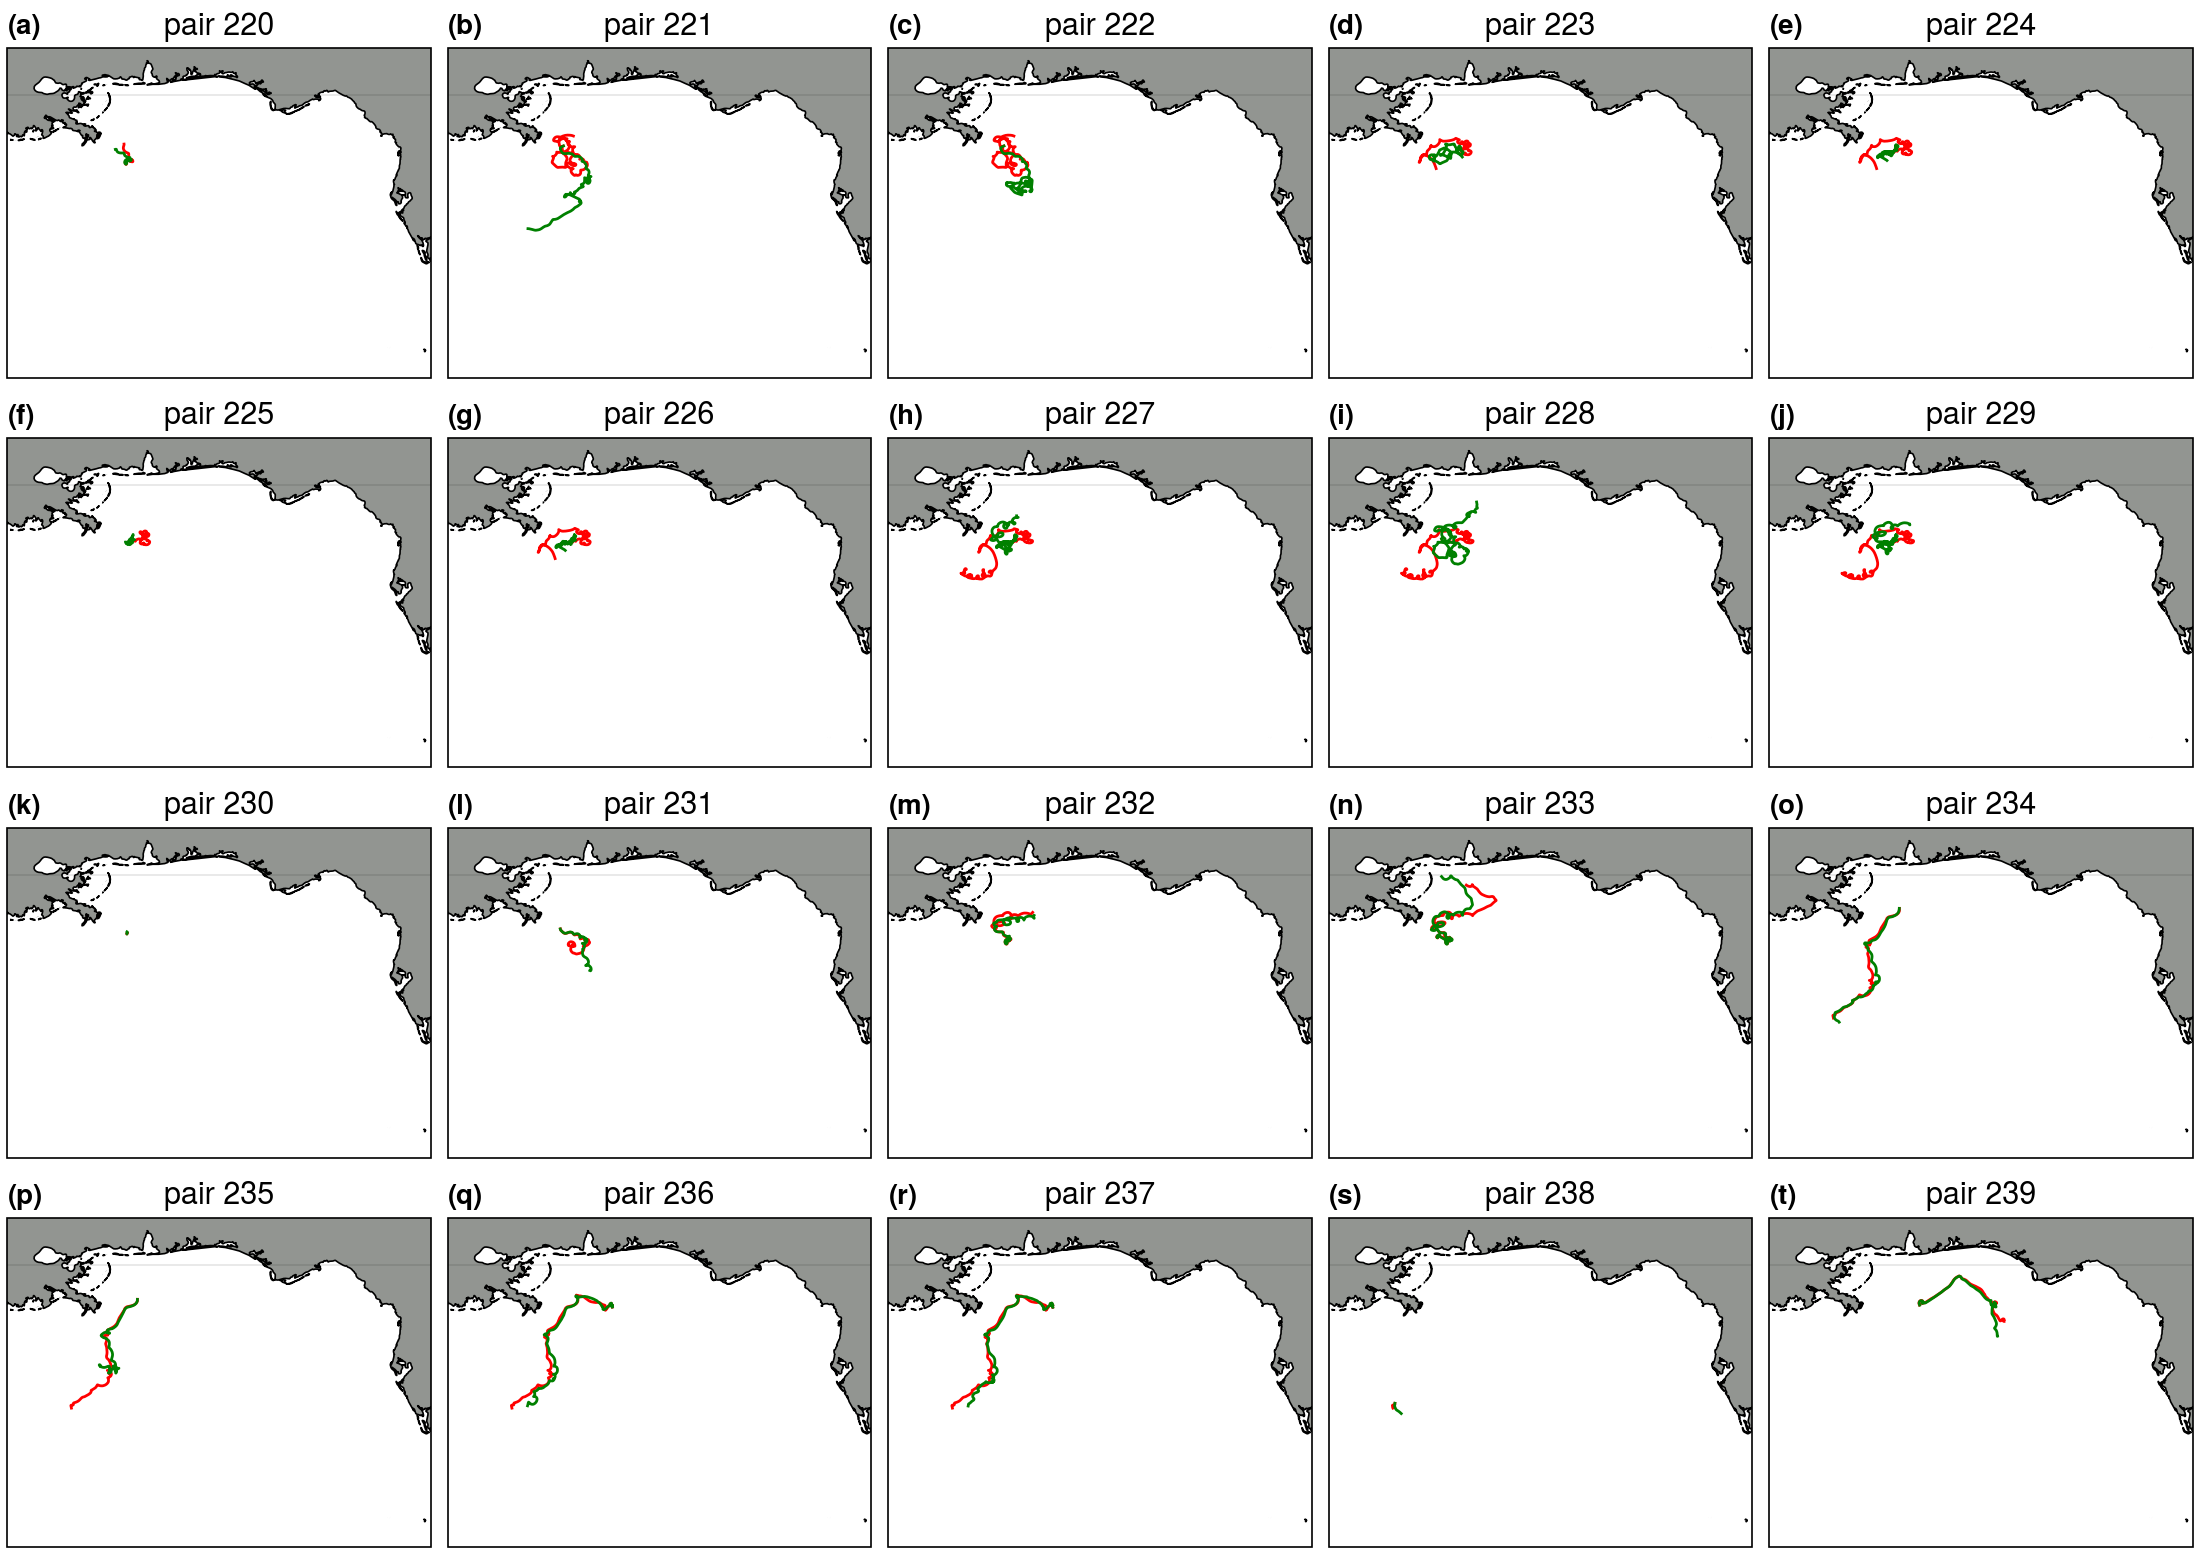

In [10]:
import proplot as pplt

fontsize = 11
lonlim = [-91, -82]
latlim = [24, 31]

grp = groups_C[2]

fig, axes = pplt.subplots(nrows=4, ncols=5, figsize=(11, 7.8), proj='cyl', facecolor='w', wspace=0.1)
startIdx = 220
for i in range(startIdx, startIdx+20):
    ax = axes[i-startIdx]
    x1 = grp[i][0].longitude
    y1 = grp[i][0].latitude
    x2 = grp[i][1].longitude
    y2 = grp[i][1].latitude
    ax.plot(x1, y1, lw=1, color='r')
    ax.plot(x2, y2, lw=1, color='g')
    ax.set_xlim(lonlim)
    ax.set_ylim(latlim)
    ax.set_title(f'pair {i}', fontsize=fontsize)
    
axes.format(abc='(a)', land=True, landcolor='gray', coast=True, reso='hi')

Check group tracks

#### 2.3 Calculate all the statistics

In [13]:
import itertools
from template import cal_all_measures

alpha = 1.2
rbin0 = 0.001 # 1 m
rbins = rd.separation_bins(rbin0, 1000, alpha, method='cist')
r0 = r0s[1]

# for original pairs
group = groups_O[1]
print(f'  original pairs of r0 = {r0} km with {len(group)} pairs')
cal_all_measures(rd, group, rbins).to_netcdf(f'../data/RDstat_LASERrft_{duration}d_{alpha}_o{r0}_{rbin0}.nc')

# for chance pairs
group = groups_C[1]
print(f'  chance pairs of r0 = {r0} km with {len(group)} pairs')
cal_all_measures(rd, group, rbins).to_netcdf(f'../data/RDstat_LASERrft_{duration}d_{alpha}_c{r0}_{rbin0}.nc')

# for original+chance pairs
group = totalpairs
print(f'  original+chance pairs of r0 = {r0} km with {len(group)} pairs')
cal_all_measures(rd, totalpairs, rbins).to_netcdf(f'../data/RDstat_LASERrft_{duration}d_{alpha}_oandc{r0}_{rbin0}.nc')

print(f'  all available pairs for S2, S3, FSLE')
K2, num_K2 = rd.relative_diffusivity(pairs, rbins, allPairs=True, reduction='mean')
S2, S2L, S2T, S3, num_s2 = rd.structure_functions(pairs, rbins, allPairs=True, reduction='mean')
FSLE_all , num_fsle = rd.FSLE(pairs, rbins, interpT=1, allPairs=True, reduction='mean')
FSLE_ifsl, num_ifsl = rd.FSLE(pairs, rbins, interpT=4, allPairs=True, reduction='mean')
FAGR, FAGRp, num_fagr, num_fagrp = rd.FAGR(pairs, rbins, allPairs=True, reduction='mean')
xr.merge([FSLE_all.rename('FSLE'), num_fsle.rename('num_fsle'), FSLE_ifsl.rename('FSLE_int'), num_ifsl.rename('num_fsle_int'),
          FAGR.rename('FAGR'), FAGRp.rename('FAGRp'), num_fagr.rename('num_fagr'), num_fagrp.rename('num_fagrp'),
          K2.rename('K2'), num_K2.rename('num_K2'),
          S2, S2L, S2T, S3, num_s2.rename('num_s2')]).to_netcdf(f'../data/RDstat_LASERrft_{duration}d_{alpha}_all_{rbin0}.nc')

  original pairs of r0 = 0.2 km with 67 pairs


100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 205.23it/s]


  chance pairs of r0 = 0.2 km with 840 pairs


100%|████████████████████████████████████████| 840/840 [00:03<00:00, 227.26it/s]


  original+chance pairs of r0 = 0.2 km with 898 pairs


100%|████████████████████████████████████████| 898/898 [00:04<00:00, 215.23it/s]


  all available pairs for S2, S3, FSLE


100%|███████████████████████████████████| 201930/201930 [42:51<00:00, 78.51it/s]
